# 00 Project Overview

This project aims to develop a profitable and robust trading strategy for the S&P 500 index using Reinforcement Learning (RL). The strategy will be trained and evaluated on historical data and backtested on out-of-sample data to assess its performance.

*This code is a part of my Diploma thesis.*

**Methodology**

The project will involve the following steps:

1. **Data Acquisition:** Obtain historical data for the S&P 500 index, including daily prices and volume data, as well as data for relevant market indicators like the VIX index.

2. **Feature Engineering:** Extract relevant features from the data, such as moving averages, relative strength index (RSI), and rate of change (ROC), to represent the market state.

3. **State Space Definition:** Define the state space for the RL agent based on the selected features and potentially market regime indicators like the VIX.

4. **Action Space Definition:** Define the action space for the RL agent, which could include discrete actions like Buy, Sell, or Hold, or continuous actions representing the portfolio allocation to the S&P 500.

5. **Reward Function Design:** Design a reward function that aligns with the desired trading objectives, such as maximizing total return, Sharpe ratio, or minimizing drawdown. This reward function will guide the RL agent's learning process.

6. **RL Algorithm Selection:** Choose an appropriate RL algorithm, such as Q-learning, SARSA, or Deep Q-Networks (DQN), to train the trading agent.

7. **Model Training:** Train the RL agent using the historical data and the defined state space, action space, reward function, and RL algorithm.

8. **Model Evaluation:** Evaluate the trained RL agent on a separate validation set of historical data to assess its performance and fine-tune its parameters.

9. **Backtesting:** Backtest the trained RL agent on out-of-sample data to simulate its performance in real-world trading scenarios.

10. **Performance Analysis:** Analyze the backtesting results, including metrics such as total return, Sharpe ratio, drawdown, and win/loss ratios, to assess the profitability and robustness of the trading strategy.

11. **Deployment and Monitoring:** If the strategy is deemed successful, it can be deployed for live trading with continuous monitoring and potential adjustments based on market conditions.

**Objectives**

The primary objective of this project is to develop a profitable and robust RL-based trading strategy for the S&P 500 index. Specific goals include:

* Achieving a Sharpe ratio higher than the benchmark (S&P 500 Buy and Hold strategy).
* Minimizing drawdown and controlling risk.
* Adapting to different market regimes and volatility levels.
* Outperforming traditional trading strategies based on technical indicators.

In [ ]:
pip install yfinance==0.2.40

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [ ]:
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

In [ ]:
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import pandas as pd

In [ ]:
import time
import itertools

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde

In [ ]:
plt.style.use('seaborn-v0_8')

In [ ]:
!pip install pandas_ta

import pandas_ta as ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=04183ab0b2449ea9fd2139ade684d48d62849b7f7b399b199f4a594a9b3a840c
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


# 01 Data

Downloading data from YahooFinance.


In [ ]:
def Download_sector_data(tickers, start_date, end_date):
    sector_data = {}
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
            sector_data[ticker] = data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
    return sector_data


sector_tickers = [
        'SPY',  # Bench
        #'^GSPE',  # Energy
        #'^SP500-15',  # Materials
        #'^SP500-20',  # Industrials
    ]

bechmark = "SPY"

# Set start and end dates
start_date = '1995-01-01'
end_date = '2023-12-31'

In [ ]:
sector_data = Download_sector_data(sector_tickers, start_date, end_date)
sectorDf = pd.concat(sector_data.values(), axis=1, keys=sector_data.keys())

spDf = yf.download(bechmark, start=start_date,  end=end_date)

vixDf = yf.download("^VIX", start=start_date,  end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 011 Regime switch identification:
If the current VIX value is above its 50-day EMA, assign a value of 1 (indicating a high-volatility or "risk-on" regime).

Otherwise, assign a value of 0 (indicating a low-volatility or "risk-off" regime).


In [ ]:
switchDf = pd.DataFrame()
switchDf["vix"] = vixDf["Close"].copy()

switchDf["EMA"] = ta.ema(switchDf["vix"], length=50)

switchDf["Switch"] = np.where(switchDf['vix'] > switchDf["EMA"], 1, 0)

In [ ]:
switchDf

,vix,EMA,Switch
Date,,,
1995-01-03,14.25,NaN,0
1995-01-04,13.53,NaN,0
1995-01-05,13.50,NaN,0
1995-01-06,13.13,NaN,0
1995-01-09,13.33,NaN,0
...,...,...,...
2023-12-22,13.03,14.191546,0
2023-12-26,12.99,14.144426,0
2023-12-27,12.43,14.077194,0


# 012 Lenght

Ensure that both dataframes have a same lenght.

In [ ]:
print(len(sectorDf))
print(len(spDf))

7300
7300


In [ ]:
def SameLenghtFCE(df1, df2):
  common_index = df2.index.intersection(df1.index)

  # Filter both DataFrames based on common index
  df2 = df2.loc[common_index]
  df1 = df1.loc[common_index]

  print("Lenght")
  print(len(df1))
  print(len(df2))

  return df1, df2



In [ ]:
spDf, sectorDf = SameLenghtFCE(spDf,sectorDf)


Lenght
7300
7300


In [ ]:
sectorDfLogRet = np.log(sectorDf/sectorDf.shift(1)).copy()
sectorDfLogRet.dropna(inplace=True)

spDfLogRet = pd.DataFrame()
spDfLogRet["LogReturns"]=np.log(spDf['Adj Close']/spDf['Adj Close'].shift(1))
spDfLogRet.dropna(inplace=True)

#02 State Representation

State representation in reinforcement learning refers to how the environment's information is encoded for the agent to make decisions. In your Q-learning project, the state is represented by the features derived from the historical market data, such as technical indicators (e.g., EMA, RSI, ROC, EFI), returns, and price ranges. These features encapsulate key aspects of the market's behavior, such as trends, momentum, and volatility, providing the agent with the necessary context to make informed trading decisions. The state representation thus transforms raw price data into a structured form that the Q-learning model can interpret for optimal decision-making.

In [ ]:
def AddEmaFCE(df, lengths):
  column = "Close"

  for length in lengths:
    column_name = f"ema_{length}"
    df[column_name] = ta.ema(df[column], length=length)

    #Relativizace
    df[column_name] = df[column_name]/df["Close"]
  return df


def AddRsiFCE(df, lengths):
  column = "Close"

  for length in lengths:
    column_name = f"rsi_{length}"
    df[column_name] = ta.rsi(df[column], length=length)
  return df


def AddRocFCE(df, lengths):
  column = "Close"

  for length in lengths:
    column_name = f"roc_{length}"
    df[column_name] = ta.roc(df[column], length=length)
  return df


def AddEfiFCE(df, lengths):
  for length in lengths:
    column_name = f"efi_{length}"
    df[column_name] = ta.efi(df["Close"],df["Volume"],length=length)
  return df


def AddReturnsFCE(df):
  df['prctRet_1'] = df['Close'].pct_change(1) * 100
  df['prctRet_2'] = df['Close'].pct_change(2) * 100
  #df['prctRet_3'] = df['Close'].pct_change(3) * 100
  #df['prctRet_4'] = df['Close'].pct_change(4) * 100
  #df['prctRet_5'] = df['Close'].pct_change(5) * 100
  return df


def AddRangeFCE(df):
  df['range_1'] = df['Low'].shift(0)-df['High'].shift(0)
  df['range_2'] = df['Low'].shift(1)-df['High'].shift(1)
  df['range_3'] = df['Low'].shift(2)-df['High'].shift(2)

  return df

In [ ]:
lengths = [5,7,15]
#lengths2 = [7,15,30,50,75,110,200]

spDf = AddReturnsFCE(spDf)
spDf = AddEmaFCE(spDf, lengths)
#spDf = AddRsiFCE(spDf, lengths)
#spDf = AddRocFCE(spDf, lengths)
#spDf = AddEfiFCE(spDf, lengths)

spDf =  AddRangeFCE(spDf)

spDf["VIX"] = vixDf["Close"]

spDf = spDf.dropna()

Check lenghts again

In [ ]:
spDf, spDfLogRet  = SameLenghtFCE(spDf,spDfLogRet)
spDf, sectorDfLogRet  = SameLenghtFCE(spDf,sectorDfLogRet)

spDf, switchDf = SameLenghtFCE(spDf,switchDf)

Lenght
7286
7286
Lenght
7286
7286
Lenght
7286
7286


In [ ]:
switchDf

,vix,EMA,Switch
Date,,,
1995-01-23,12.79,NaN,0
1995-01-24,11.94,NaN,0
1995-01-25,11.46,NaN,0
1995-01-26,11.25,NaN,0
1995-01-27,11.25,NaN,0
...,...,...,...
2023-12-22,13.03,14.191546,0
2023-12-26,12.99,14.144426,0
2023-12-27,12.43,14.077194,0


# 03 Data Split

This section focuses on splitting the data into training and testing sets.

In [ ]:
split_date = '2015-01-01'


sectorDfLogRetTrain = sectorDfLogRet.loc[sectorDfLogRet.index <= split_date].copy()
sectorDfLogRetTest = sectorDfLogRet.loc[sectorDfLogRet.index > split_date].copy()

sectorDfTrain = sectorDf.loc[sectorDf.index <= split_date].copy()
sectorDfTest = sectorDf.loc[sectorDf.index > split_date].copy()


spDfTrain = spDf.loc[spDf.index <= split_date].copy()
spDfTest = spDf.loc[spDf.index > split_date].copy()

spDfLogRetTrain = spDfLogRet.loc[spDfLogRet.index <= split_date].copy()
spDfLogRetTest = spDfLogRet.loc[spDfLogRet.index > split_date].copy()



switchDfTrain = switchDf.loc[switchDf.index <= split_date].copy()
switchDfTest = switchDf.loc[switchDf.index > split_date].copy()


In [ ]:
marketDfLogRetTrain = sectorDfLogRetTrain.copy()
marketDfLogRetTest = sectorDfLogRetTest.copy()

marketDfLogRetTrain['SPY'] = spDfLogRetTrain.LogReturns
marketDfLogRetTest['SPY'] = spDfLogRetTest.LogReturns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit scaler to the data and transform the data
spDfTrainScale = scaler.fit_transform(spDfTrain.iloc[:, 7:])
spDfTestScale = scaler.transform(spDfTest.iloc[:, 7:])


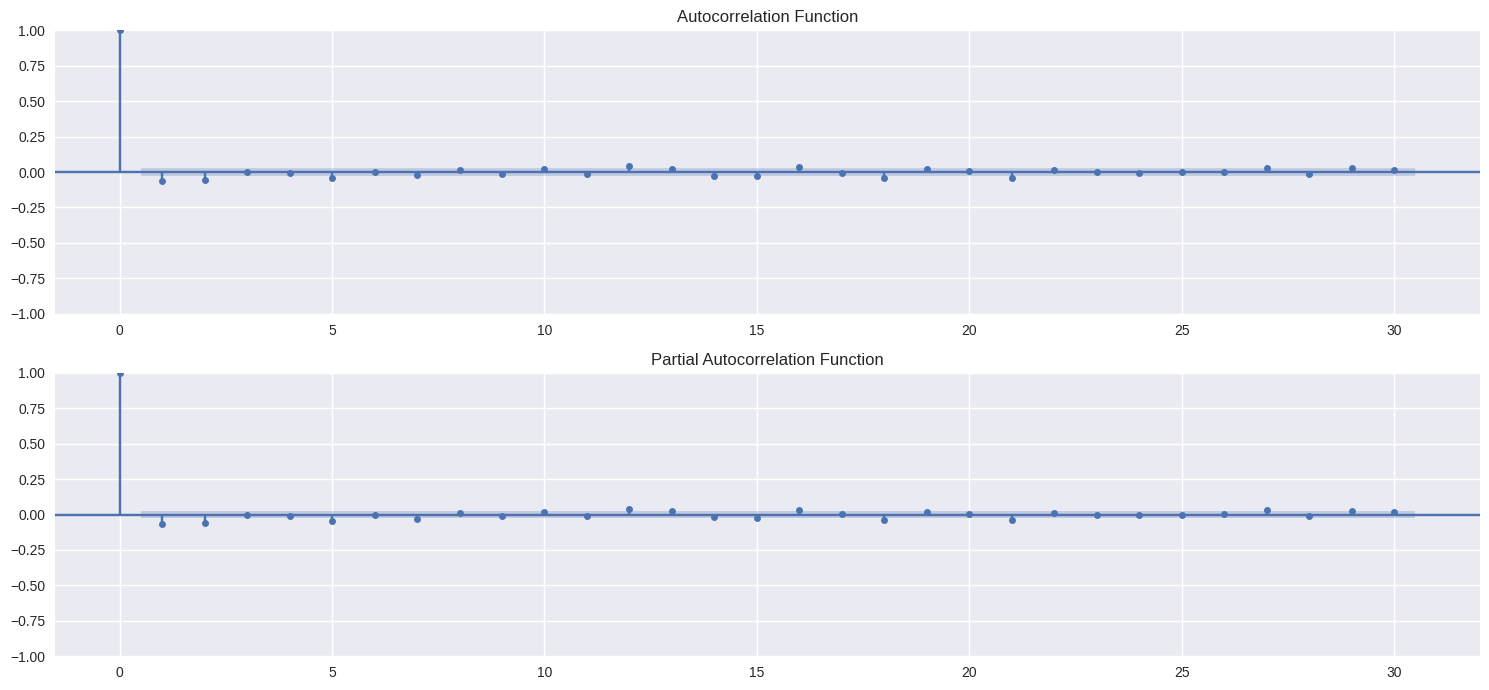

In [ ]:
def plot_acf_pacf(data_series):
    plt.figure(figsize=(15, 7))

    plt.subplot(211)
    plot_acf(data_series, ax=plt.gca(), lags=30)
    plt.title('Autocorrelation Function')

    plt.subplot(212)
    plot_pacf(data_series, ax=plt.gca(), lags=30)
    plt.title('Partial Autocorrelation Function')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(spDfLogRetTrain['LogReturns'])


#04 Actions

This section defines the possible actions that the RL agent can take in the trading environment.



##041 Action Matrix

Define the possible portfolio allocation percentages for each asset. These values represent the percentage of the portfolio to be allocated to each asset

In [ ]:
#values_list = [-25, 0, 50, 100, 125]
values_list = [0, 100, 150]

#values_list = [0, 25, 50, 75, 100]
#values_list = [0, 25, 50]

In [ ]:
num_rows = 5000000

actionsDf = pd.DataFrame(index=range(num_rows), columns=marketDfLogRetTrain.columns)

def generate_random_value(col):
    return np.random.choice(values_list, size=num_rows)

actionsDf = actionsDf.apply(generate_random_value)

Check restrictions

In [ ]:
row_sums = actionsDf.sum(axis=1)

# Filter rows based on condition
actionsDf = actionsDf[(row_sums >= -50) & (row_sums <= 150)]
# Reset index
actionsDf = actionsDf.reset_index(drop=True)

actionsDf = actionsDf.drop_duplicates()

#########
negative_sums = actionsDf.apply(lambda row: sum(filter(lambda x: x < 0, row)), axis=1)

# Filter rows based on condition
actionsDf = actionsDf[negative_sums >= -50]

actionsDf.reset_index(drop=True, inplace=True)
actionsDf = actionsDf/100

#
print('velikost')
print(len(actionsDf))

velikost
3


In [ ]:
actionsDf

,SPY
0,1.0
1,0.0
2,1.5


In [ ]:
"""
Buy Sell Buy Sell
[[0,0],
[0,25],
[0,50],
[0,75],
[0,100],
[25,0],
[50,0],
[75,0],
[100,0]]
"""


'\nBuy Sell Buy Sell\n[[0,0],\n[0,25],\n[0,50],\n[0,75],\n[0,100],\n[25,0],\n[50,0],\n[75,0],\n[100,0]]\n'

-----------------

#05 Q Learning

Q-learning is a model-free reinforcement learning algorithm used to find the optimal action-selection policy for an agent. It works by learning the value of state-action pairs, represented in a Q-table, which indicates the expected reward for taking a certain action in a given state. The agent updates the Q-values iteratively based on rewards it receives after taking actions, with the goal of maximizing cumulative future rewards. Over time, Q-learning enables the agent to choose actions that lead to the highest long-term reward, making it useful for decision-making in dynamic environments like trading.

## 051 Functions



In [ ]:
def RLTrain_SimpleReward(alpha, epsilon, num_episodes, marketDfLogRetTrain, actionsDf):

  #Params
  marketArr = np.array(marketDfLogRetTrain)
  actionsArr = np.array(actionsDf)

  num_actions = len(actionsArr)
  num_states = len(marketArr) # You can expand this for more features
  q_table = np.zeros((num_states, num_actions))


  #Train
  for x in range(num_episodes):

      randomActions = np.random.choice(num_actions, size=10000)
      randomExploit = np.random.uniform(0, 1, size = 10000)
      current_state = 0
      #start_time = time.time()
      logPortfolioRet = []

      while current_state < len(marketDfLogRetTrain)-5:

          #-----------------------------------------------------------------------
          if randomExploit[current_state] < epsilon:
              action = randomActions[current_state]  # Explore
          else:
              action = np.argmax(q_table[current_state])  # Exploit

          #-----------------------------------------------------------------------
          t1 = np.sum(marketArr[current_state+1] * actionsArr[action])
          t2 = np.sum(marketArr[current_state+2] * actionsArr[action])
          t3 = np.sum(marketArr[current_state+3] * actionsArr[action])
          t4 = np.sum(marketArr[current_state+4] * actionsArr[action])
          t5 = np.sum(marketArr[current_state+5] * actionsArr[action])

          logPortfolioRet.append(t1)

          #R-----------------------------------------------------------------------
          reward = 0.9*t1 + 0.7*t2 + 0.5*t3 + 0.2*t4 + 0.1*t5

          #-----------------------------------------------------------------------
          q_table[current_state, action] = (1 - alpha) * q_table[current_state, action] + alpha * reward

          current_state += 1
          #-----------------------------------------------------------------------

  logEquity = cumulative_sum = list(itertools.accumulate(logPortfolioRet))

  return q_table, logPortfolioRet, logEquity

In [ ]:
def RLTrain_SimpleReward3(alpha, epsilon, num_episodes, marketDfLogRetTrain, actionsDf, switchDfTrain):

  #Params
  marketArr = np.array(marketDfLogRetTrain)
  actionsArr = np.array(actionsDf)

  num_actions = len(actionsArr)
  num_states = len(marketArr) # You can expand this for more features
  q_table = np.zeros((num_states, num_actions))


  #Train
  for x in range(num_episodes):

      randomActions = np.random.choice(num_actions, size=10000)
      randomExploit = np.random.uniform(0, 1, size = 10000)
      current_state = 0
      #start_time = time.time()
      logPortfolioRet = []

      while current_state < len(marketDfLogRetTrain)-5:

          #-----------------------------------------------------------------------
          if randomExploit[current_state] < epsilon:
              action = randomActions[current_state]  # Explore
          else:
              action = np.argmax(q_table[current_state])  # Exploit

          #-----------------------------------------------------------------------
          t1 = np.sum(marketArr[current_state+1] * actionsArr[action])
          t2 = np.sum(marketArr[current_state+2] * actionsArr[action])
          t3 = np.sum(marketArr[current_state+3] * actionsArr[action])
          t4 = np.sum(marketArr[current_state+4] * actionsArr[action])
          t5 = np.sum(marketArr[current_state+5] * actionsArr[action])

          logPortfolioRet.append(t1)

          #R-----------------------------------------------------------------------
          reward = 0.9*t1 + 0.7*t2 + 0.5*t3 + 0.2*t4 + 0.1*t5

          #-----------------------------------------------------------------------

          if switchDfTrain["Switch"][current_state] == 0:

            q_table[current_state, action] = (1 - alpha) * q_table[current_state, action] + alpha * reward

          else:
            q_table[current_state, action] = (1 - alpha) * q_table[current_state, action] + alpha * reward



          current_state += 1
          #-----------------------------------------------------------------------

  logEquity = cumulative_sum = list(itertools.accumulate(logPortfolioRet))

  return q_table, logPortfolioRet, logEquity

##052 Run Train

Parameters

In [ ]:
alpha = 0.1  # Learning rate
gamma = 0.0000000000020  # Discount factor
epsilon = 0.3  # Exploration rate
num_episodes = 200
#np.random.seed(0)

In [ ]:
#q_table, logPortfolioRet, logEquity = RLTrain_SimpleReward(alpha, epsilon, num_episodes, marketDfLogRetTrain, actionsDf)

In [ ]:
q_table, logPortfolioRet, logEquity = RLTrain_SimpleReward3(alpha, epsilon, num_episodes, marketDfLogRetTrain, actionsDf, switchDfTrain)

<ipython-input-33-064a10f35580>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if switchDfTrain["Switch"][current_state] == 0:


In [ ]:
switchDfTrain

,vix,EMA,Switch
Date,,,
1995-01-23,12.790000,NaN,0
1995-01-24,11.940000,NaN,0
1995-01-25,11.460000,NaN,0
1995-01-26,11.250000,NaN,0
1995-01-27,11.250000,NaN,0
...,...,...,...
2014-12-24,14.370000,15.592168,0
2014-12-26,14.500000,15.549337,0
2014-12-29,15.060000,15.530148,0


In [ ]:
'''
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time:", execution_time)
    execution_timeA.append(execution_time)
'''

'\n    end_time = time.time()\n    execution_time = end_time - start_time\n    print("Execution time:", execution_time)\n    execution_timeA.append(execution_time)\n'

##053 Plot Q Train

In [ ]:
plotDfTrain = pd.DataFrame(marketDfLogRetTrain['SPY']).copy()
plotDfTrain['SPY'] = plotDfTrain['SPY'].cumsum()

#Reward Train shorter by 5
plotDfTrain = plotDfTrain[:-5]

plotDfTrain['TrainQ'] = logEquity

In [ ]:
plotDfTrain


,SPY,TrainQ
Date,,
1995-01-23,0.003017,0.002007
1995-01-24,0.004355,0.002007
1995-01-25,0.007025,0.003506
1995-01-26,0.008024,0.009489
1995-01-27,0.012013,0.005168
...,...,...
2014-12-17,1.818971,16.987466
2014-12-18,1.843399,16.993835
2014-12-19,1.847645,16.998424


The plot shows the comparison between the optimal Q-values (Q Optimal) and the observed SPY equity over time. While the Q Optimal values reflect the agent's performance, the observed SPY line represents the actual market behavior, offering insight into how closely the agent's decisions align with real-world returns.

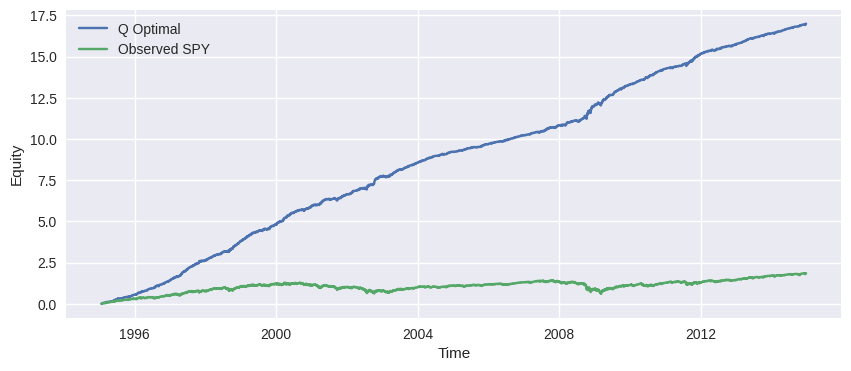

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(plotDfTrain['TrainQ'], label='Q Optimal')
plt.plot(plotDfTrain['SPY'], label='Observed SPY')

plt.xlabel('Time')
plt.ylabel('Equity')
#plt.title('Development of Equity Over Time')

#plt.grid(True)
plt.legend()
plt.show()

#06 Supervised / assign states

Assigning new states to known states involves mapping the current state of the agent to previously learned states in the training set. This step allows the agent to apply its learned knowledge to new, unseen situations by generalizing from the training data. The process helps the agent efficiently navigate the environment, ensuring that its decision-making is based on the most relevant information from its past experiences. This approach also reduces the need for retraining from scratch, speeding up the learning process in dynamic environments.

In [ ]:
# Because of reward, not know q value for last 5 obs.

spDfTrainScale2 = pd.DataFrame(spDfTrainScale).copy()
#spDfTrainScale2 = spDfTrainScale2[:-5]

###Limit train clusterts given state

In [ ]:
switchDfTrain2 = switchDfTrain.copy()
switchDfTrain2.reset_index(drop=True, inplace=True)

filtered_df = switchDfTrain2[switchDfTrain2['Switch'] == 1]

# Get the list of indices where the condition is met
indices_to_drop = filtered_df.index.tolist()

In [ ]:
spDfTrainScale2.drop(indices_to_drop)

,0,1,2,3,4,5,6,7
0,-0.082879,0.060405,0.014133,-0.214929,1.047814,1.286159,1.313981,-0.948397
1,0.213772,-0.030975,-0.053508,-0.235855,1.385059,1.047291,1.285882,-1.049195
2,0.193270,-0.177336,-0.181319,-0.311995,1.005659,1.384517,1.047043,-1.106116
3,0.173254,-0.167558,-0.180330,-0.305996,1.272644,1.005138,1.384228,-1.131019
4,0.251267,-0.352501,-0.352256,-0.430267,1.202385,1.272108,1.004895,-1.131019
...,...,...,...,...,...,...,...,...
5015,0.153237,-0.969399,-0.935216,-0.622595,0.575114,-0.063868,-6.654815,-0.656675
5016,0.307607,-0.717285,-0.765191,-0.592555,0.736985,0.574618,-0.063981,-0.710039
5017,0.041781,-0.469520,-0.565907,-0.512248,0.925848,0.736480,0.574428,-0.761031
5018,0.152319,-0.503983,-0.596156,-0.576889,0.943825,0.925332,0.736270,-0.745615


## 061 K Means Clustering

K-means clustering is an unsupervised learning algorithm used to partition data into K distinct clusters based on similarity. It works by iteratively assigning data points to the nearest cluster centroid and updating the centroids based on the mean of the assigned points. This process continues until convergence, where the centroids no longer change significantly. K-means is efficient and widely used for grouping data, but it requires the number of clusters (K) to be predefined and can be sensitive to the initial placement of centroids, potentially leading to different results in different runs.

KM 2

In [ ]:
model = KMeans(n_clusters=3, random_state=0, n_init=300)
# fit the model
model.fit(spDfTrainScale2)

init_means2 = model.cluster_centers_

trainClustersKM2 = model.predict(spDfTrainScale)
testClustersKM2 = model.predict(spDfTestScale)

KM 5

In [ ]:
model = KMeans(n_clusters=5, random_state=0, n_init=300)
# fit the model
model.fit(spDfTrainScale2)

init_means5 = model.cluster_centers_

trainClustersKM5 = model.predict(spDfTrainScale)
testClustersKM5 = model.predict(spDfTestScale)

KM 10

In [ ]:
model = KMeans(n_clusters=7, random_state=0, n_init=300)
# fit the model
model.fit(spDfTrainScale2)

init_means10 = model.cluster_centers_

trainClustersKM10 = model.predict(spDfTrainScale)
testClustersKM10 = model.predict(spDfTestScale)

KM 20

In [ ]:
model = KMeans(n_clusters=9, random_state=0, n_init=300)
# fit the model
model.fit(spDfTrainScale2)

init_means20 = model.cluster_centers_

trainClustersKM20 = model.predict(spDfTrainScale)
testClustersKM20 = model.predict(spDfTestScale)

## 062 GaussianMixture

Gaussian Mixture Models (GMM) are a probabilistic model that assumes the data is generated from a mixture of several Gaussian distributions. Each Gaussian component represents a cluster, with a unique mean and variance. GMM is more flexible than K-means as it can model elliptical clusters with varying shapes and sizes, making it suitable for complex data distributions. It assigns a probability to each data point belonging to each cluster, rather than a hard assignment like K-means. However, GMM can be computationally more expensive and also requires the number of components (clusters) to be predefined.

GM 2

In [ ]:
model = GaussianMixture(n_components=3, means_init=init_means2, random_state=111, n_init=3)
model.fit(spDfTrainScale2)


trainClustersGM2 = model.predict(spDfTrainScale)
testClustersGM2 = model.predict(spDfTestScale)

GM 5

In [ ]:
model = GaussianMixture(n_components=5,means_init=init_means5, random_state=111, n_init=3)
model.fit(spDfTrainScale2)


trainClustersGM5 = model.predict(spDfTrainScale)
testClustersGM5 = model.predict(spDfTestScale)

GM 10

In [ ]:
model = GaussianMixture(n_components =7, means_init=init_means10 ,random_state=111,n_init=3)
model.fit(spDfTrainScale)


trainClustersGM10 = model.predict(spDfTrainScale)
testClustersGM10 = model.predict(spDfTestScale)

GM 20

In [ ]:
model = GaussianMixture(n_components=9, means_init=init_means20, random_state=111, n_init=3)
model.fit(spDfTrainScale)


trainClustersGM20 = model.predict(spDfTrainScale)
testClustersGM20 = model.predict(spDfTestScale)

## 063 Other functions

Find cluster for every on seen observation.

In [ ]:
def ClustersObservations(trainClusters):

  #------------------------------
  #01 Combine
  # Cluster 0 consists of observations at indices ... observIndex,
  # Cluster 1 consists of ...
  # The entire structure is called clusterObservsList

  unique_values = np.unique(trainClusters)

  clusterObservList = []

  for unique in unique_values:

    observIndex = []
    for x in range(len(trainClusters)):

      if unique == trainClusters[x]:

        observIndex.append(x)


    clusterObservList.append(observIndex)

  return clusterObservList

Create a mean from this clusters to assign action values to particular state

In [ ]:
#Jakou akci delat v jakem clusteru
# Kluster 0 q value pro kazdou akci
def Policy(clusterObservList):
  clusterActions = []

  for x in range(len(clusterObservList)):
    clusterQ_table =  q_table[clusterObservList[x]]

    #!!!!!!!!!!!!!!!!
    column_means = np.mean(clusterQ_table, axis=0)

    clusterActions.append(column_means)

  return clusterActions

Cluster action to Q table

In [ ]:
  marketArr = np.array(marketDfLogRetTrain)
  actionsArr = np.array(actionsDf)


  num_actions = len(actionsArr)
  num_states = len(marketArr) # You can expand this for more features
  q_tableTest = np.zeros((num_states, num_actions))

In [ ]:
def QTableTest(marketDfLogRetTest, actionsDf, clusterActions, testClusters):

  # Convert DataFrames to NumPy arrays for faster calculations
  marketArr = np.array(marketDfLogRetTest)
  actionsArr = np.array(actionsDf)

  # Get the number of actions and states
  num_actions = len(actionsArr)  # Number of possible portfolio allocations
  num_states = len(marketArr)    # Number of observations in the testing data

  # Initialize the Q-table for the testing data with zeros
  q_tableTest = np.zeros((num_states, num_actions))

  # Iterate through each cluster and assign the corresponding actions to the Q-table
  for cluster in range(len(clusterActions)):
    for x in range(len(q_tableTest)):
      # If the current observation belongs to the current cluster
      if testClusters[x] == cluster:
        # Assign the pre-determined actions (Q-values) for that cluster to the Q-table
        q_tableTest[x] = clusterActions[cluster]

  # Return the Q-table, market array, and actions array
  return q_tableTest, marketArr, actionsArr


## 064 Backtester LogRet

In [ ]:
def Backtester(marketDfLogRetTest, q_tableTest, marketArr, actionsArr, switchDfTrain):

    logEquity = []
    logPortfolioRet = []
    actionArrPositions = []

    current_state = 0

    while current_state < len(marketDfLogRetTest)-1:
        # Select the action with the highest Q-value for the current state
        action = np.argmax(q_tableTest[current_state])

        # Calculate the portfolio return for the next time step using the selected action
        t1 = np.sum(marketArr[current_state+1] * actionsArr[action])

        # Apply regime-based logic
        if switchDfTrain["Switch"][current_state] == 0:  # If in low-volatility regime
            logPortfolioRet.append(t1)  # Use the Q-learning action
            actionArrPositions.append(actionsArr[action])  # Record the action
        else:  # If in high-volatility regime
            logPortfolioRet.append(np.sum(marketArr[current_state+1] * 0.50))  # Allocate 50% to SPY (risk-off)
            actionArrPositions.append(0.5)  # Record the risk-off action

        # Move to the next time step
        current_state += 1

    # Calculate the cumulative log returns (equity curve)
    logEquity = list(itertools.accumulate(logPortfolioRet))

    return logEquity, logPortfolioRet, actionArrPositions

#07 Run Simulation

In [ ]:
def RunSim(trainClusters, testClusters, marketDfLogRetTest, actionsDf, switchDfTrain):

  clusterObservList = ClustersObservations(trainClusters)
  clusterActions = Policy(clusterObservList)
  q_tableTest, marketArr, actionsArr = QTableTest(marketDfLogRetTest, actionsDf, clusterActions, testClusters)

  logEquity, logPortfolioRet, actionArrPositions = Backtester(marketDfLogRetTest, q_tableTest, marketArr, actionsArr, switchDfTrain)

  return logEquity, logPortfolioRet

In [ ]:
def RunSim2(trainClusters, testClusters, marketDfLogRetTest, actionsDf, switchDfTest):

  clusterObservList = ClustersObservations(trainClusters)
  clusterActions = Policy(clusterObservList)
  q_tableTest, marketArr, actionsArr = QTableTest(marketDfLogRetTest, actionsDf, clusterActions, testClusters)

  logEquity, logPortfolioRet, actionArrPositions = Backtester(marketDfLogRetTest, q_tableTest, marketArr, actionsArr, switchDfTest)

  return logEquity, logPortfolioRet, actionArrPositions

In [ ]:
# MENIT POUZE CLUSTERY
# trainClustersKNN10, testClustersKNN10, marketDfLogRetTest

# Prejmenovat vystup
'''
clusterObservList = ClustersObservations(trainClustersKNN10)
clusterActions = Policy(clusterObservList)
q_tableTest, marketArr, actionsArr = QTableTest(marketDfLogRetTest, actionsDf, clusterActions, testClustersKNN10)

logEquity, logPortfolioRet = Backtester(marketDfLogRetTest, q_tableTest, marketArr, actionsArr)
'''

'\nclusterObservList = ClustersObservations(trainClustersKNN10)\nclusterActions = Policy(clusterObservList)\nq_tableTest, marketArr, actionsArr = QTableTest(marketDfLogRetTest, actionsDf, clusterActions, testClustersKNN10)\n\nlogEquity, logPortfolioRet = Backtester(marketDfLogRetTest, q_tableTest, marketArr, actionsArr)\n'

In [ ]:
tlogEquityKM2, tlogPortfolioRetKM2 = RunSim(trainClustersKM2, trainClustersKM2, marketDfLogRetTrain, actionsDf, switchDfTrain)
tlogEquityKM5, tlogPortfolioRetKM5 = RunSim(trainClustersKM5, trainClustersKM5, marketDfLogRetTrain, actionsDf, switchDfTrain)
tlogEquityKM10, tlogPortfolioRetKM10 = RunSim(trainClustersKM10, trainClustersKM10, marketDfLogRetTrain, actionsDf, switchDfTrain)
tlogEquityKM20, tlogPortfolioRetKM20 = RunSim(trainClustersKM20, trainClustersKM20, marketDfLogRetTrain, actionsDf, switchDfTrain)

tlogEquityGM2, tlogPortfolioRetGM2 = RunSim(trainClustersGM2, trainClustersGM2, marketDfLogRetTrain, actionsDf, switchDfTrain)
tlogEquityGM5, tlogPortfolioRetGM5 = RunSim(trainClustersGM5, trainClustersGM5, marketDfLogRetTrain, actionsDf, switchDfTrain)
tlogEquityGM10, tlogPortfolioRetGM10 = RunSim(trainClustersGM10, trainClustersGM10, marketDfLogRetTrain, actionsDf, switchDfTrain)
tlogEquityGM20, tlogPortfolioRetGM20 = RunSim(trainClustersGM20, trainClustersGM20, marketDfLogRetTrain, actionsDf, switchDfTrain)

<ipython-input-57-fc154dfae8e6>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if switchDfTrain["Switch"][current_state] == 0:  # If in low-volatility regime


# 08 Plot Results

## 081 Plot Train

In [ ]:
plotDfTrain = pd.DataFrame(marketDfLogRetTrain['SPY']).copy()
plotDfTrain['SPY'] = plotDfTrain['SPY'].cumsum()

#Reward Train shorter by 1 default bytester
plotDfTrain = plotDfTrain[:-1]  # train -1

#--------------------------------
#BENCHAMR HERE !!!!!! ADD
plotDfTrainRet = pd.DataFrame(marketDfLogRetTrain['SPY']).copy()

#Reward Train shorter by 1 default bytester
plotDfTrainRet = plotDfTrainRet[:-1]

In [ ]:
plotDfTrain['KM2'] = tlogEquityKM2
plotDfTrain['KM5'] = tlogEquityKM5
plotDfTrain['KM10'] = tlogEquityKM10
plotDfTrain['KM20'] = tlogEquityKM20

plotDfTrain['GM2'] = tlogEquityGM2
plotDfTrain['GM5'] = tlogEquityGM5
plotDfTrain['GM10'] = tlogEquityGM10
plotDfTrain['GM20'] = tlogEquityGM20


plotDfTrainRet['KM2'] = tlogPortfolioRetKM2
plotDfTrainRet['KM5'] = tlogPortfolioRetKM5
plotDfTrainRet['KM10'] = tlogPortfolioRetKM10
plotDfTrainRet['KM20'] = tlogPortfolioRetKM20

plotDfTrainRet['GM2'] = tlogPortfolioRetGM2
plotDfTrainRet['GM5'] = tlogPortfolioRetGM5
plotDfTrainRet['GM10'] = tlogPortfolioRetGM10
plotDfTrainRet['GM20'] = tlogPortfolioRetGM20

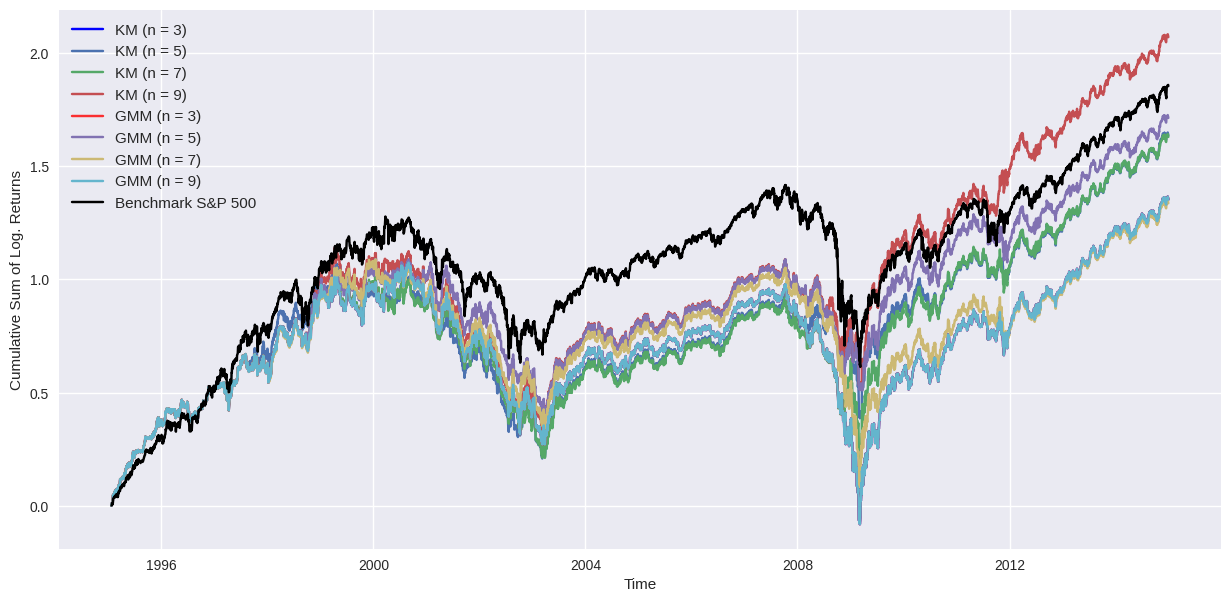

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(plotDfTrain['KM2'], label='KM (n = 3)', color =  'blue', alpha = 1)
plt.plot(plotDfTrain['KM5'], label='KM (n = 5)', alpha = 1)
plt.plot(plotDfTrain['KM10'], label='KM (n = 7)', alpha = 1)
plt.plot(plotDfTrain['KM20'], label='KM (n = 9)', alpha = 1)

plt.plot(plotDfTrain['GM2'], label='GMM (n = 3)',color = 'red', alpha = 0.8)
plt.plot(plotDfTrain['GM5'], label='GMM (n = 5)', alpha = 1)
plt.plot(plotDfTrain['GM10'], label='GMM (n = 7)', alpha = 1)
plt.plot(plotDfTrain['GM20'], label='GMM (n = 9)', alpha = 1)

plt.plot(plotDfTrain['SPY'], label='Benchmark S&P 500', color = 'black', alpha = 0.99998)


plt.xlabel('Time', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)
#plt.title('Development of Equity Over Time')

#plt.grid(True)
plt.legend(fontsize=11)
plt.show()

Graph shows results on train data.

In [ ]:
plotDfTrainRet.to_csv('Train.csv', sep=',', encoding='utf-8', index=False, compression='gzip')

In [ ]:
def Stats(plotDfTrainRet):

  # Assuming 'df' is your DataFrame with returns in columns
  dfTrainStats = pd.DataFrame()
  # Calculate total return for each column
  dfTrainStats['TotRet'] = plotDfTrainRet.sum(axis=0)

  # Calculate average return for each column
  dfTrainStats['AvgRet'] = plotDfTrainRet.mean(axis=0)

  # Calculate standard deviation of returns (smdch) for each column
  dfTrainStats['Std'] = plotDfTrainRet.std(axis=0)

  # Assuming risk-free rate is 0.05 (adjust as needed)
  risk_free_rate = 0.02/252

#--------------------------------------------------------
  # Max DD
  dfTrainStats_cumulative = (plotDfTrainRet).cumsum()

  # Calculate the rolling maximum of the cumulative returns to date for each column
  rolling_max = dfTrainStats_cumulative.cummax()

  # Calculate drawdown: subtract the cumulative returns from the rolling maximum
  drawdown = (rolling_max - dfTrainStats_cumulative)#/rolling_max

  # Calculate the maximum drawdown: this is the largest drop from the peak, so we take the maximum of the drawdown
  max_drawdown = drawdown.max()
  dfTrainStats['MaxDrawdown'] = max_drawdown

#--------------------------------------------------------

  def downside_deviation(returns, target=0):
      # Here we calculate the downside deviations only
      downside_diffs = np.where(returns < target, returns - target, 0)
      downside_dev = np.sqrt(np.mean(downside_diffs ** 2))
      return downside_dev


  dfTrainStats['DownsideDev'] = plotDfTrainRet.apply(lambda x: downside_deviation(x - risk_free_rate), axis=0)
#--------------------------------------------------------

  # SHARPE
  # Calculate Sharpe ratio for each column
  dfTrainStats['SharpeRatioAnl'] = ((dfTrainStats['AvgRet'] - risk_free_rate) / dfTrainStats['Std'])*np.sqrt(252)
  dfTrainStats['SharpeRatioTot'] = ((dfTrainStats['AvgRet'] - risk_free_rate) / dfTrainStats['Std'])*np.sqrt(len(plotDfTrainRet))
  # SORTINO
  # Calculate Sortino Ratio
  dfTrainStats['SortinoRatioAnl'] = (dfTrainStats['AvgRet'] - risk_free_rate) / dfTrainStats['DownsideDev'] * np.sqrt(252)
  dfTrainStats['SortinoRatioTot'] = (dfTrainStats['AvgRet'] - risk_free_rate) / dfTrainStats['DownsideDev'] * np.sqrt(len(plotDfTrainRet))


  #---------------------------------------------------------
  # INFORMATION ratio
  excess_returns = plotDfTrainRet - plotDfTrainRet['SPY']

  information_ratio = []
  benchmark_returns = plotDfTrainRet['SPY']
  for strategy in plotDfTrainRet:
      if strategy != 'SPYZZZZ':
          ret = plotDfTrainRet[strategy] - benchmark_returns
          #print("ret")
          ##print(ret.mean())
          #print(ret.std())
          ir = ret.mean() / ret.std() * np.sqrt(len(plotDfTrainRet))
          #print(ir)
          information_ratio.append(ir)

  # Calculate annualized excess return and annualized tracking error
  annualized_excess_return = excess_returns.mean() * 252  # Assuming 252 trading days per year
  annualized_tracking_error = excess_returns.std() * np.sqrt(252)

  dfTrainStats['InformationRatioTot'] = information_ratio

#MW-----------------------------------------------------------------------------


  # Calculate Mann-Whitney U test for each strategy compared to Strategy 1 (benchmark)
  mw_results = {}
  p_val = [0]
  benchmark_returns = plotDfTrainRet['SPY']
  for strategy in plotDfTrainRet:
      if strategy != 'SPY':
          statistic, p_value = mannwhitneyu(benchmark_returns, plotDfTrainRet[strategy])
          mw_results[strategy] = {'Mann-Whitney U statistic': statistic, 'p-value': p_value}
          p_val.append(p_value)

  dfTrainStats['MW p-val'] = p_val

  # ANL------------------
  dfTrainStats['AvgRet'] = dfTrainStats['AvgRet']*252*100
  dfTrainStats['Std'] = dfTrainStats['Std']*np.sqrt(252)*100
  dfTrainStats['TotRet'] = dfTrainStats['TotRet']*100
  dfTrainStats['MaxDrawdown'] = dfTrainStats['MaxDrawdown']*100

  dfTrainStats = dfTrainStats.round(3)

  return dfTrainStats

Stats(plotDfTrainRet)

<ipython-input-66-bf5549142154>:65: RuntimeWarning: invalid value encountered in scalar divide
  ir = ret.mean() / ret.std() * np.sqrt(len(plotDfTrainRet))


,TotRet,AvgRet,Std,MaxDrawdown,DownsideDev,SharpeRatioAnl,SharpeRatioTot,SortinoRatioAnl,SortinoRatioTot,InformationRatioTot,MW p-val
SPY,185.286,9.299,19.722,80.273,0.009,0.370,1.652,0.518,2.313,NaN,0.000
KM2,135.244,6.788,19.616,115.399,0.009,0.244,1.089,0.335,1.497,-0.395,0.682
KM5,163.533,8.208,17.068,85.893,0.008,0.364,1.623,0.505,2.256,-0.184,0.424
KM10,162.866,8.174,18.861,82.501,0.009,0.327,1.461,0.456,2.034,-0.181,0.700
KM20,206.885,10.383,18.087,80.650,0.008,0.464,2.069,0.654,2.919,0.179,0.743
GM2,135.244,6.788,19.616,115.399,0.009,0.244,1.089,0.335,1.497,-0.395,0.682
GM5,171.227,8.594,18.238,71.553,0.008,0.362,1.614,0.503,2.243,-0.115,0.661
GM10,133.610,6.706,19.210,100.288,0.009,0.245,1.093,0.335,1.497,-0.412,0.613
GM20,135.244,6.788,19.616,115.399,0.009,0.244,1.089,0.335,1.497,-0.395,0.682


In [ ]:
len(plotDfTrainRet)

5021

In [ ]:
plotDfTrainRet

,SPY,KM2,KM5,KM10,KM20,GM2,GM5,GM10,GM20
Date,,,,,,,,,
1995-01-23,0.003017,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007
1995-01-24,0.001338,0.004005,0.004005,0.004005,0.004005,0.004005,0.004005,0.004005,0.004005
1995-01-25,0.002670,0.001499,0.001499,0.001499,0.001499,0.001499,0.001499,0.001499,0.001499
1995-01-26,0.000999,0.005983,0.005983,0.005983,0.005983,0.005983,0.005983,0.005983,0.005983
1995-01-27,0.003988,-0.006482,-0.006482,-0.006482,-0.006482,-0.006482,-0.006482,-0.006482,-0.006482
...,...,...,...,...,...,...,...,...,...
2014-12-23,0.001349,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144
2014-12-24,0.000096,0.004830,0.004830,0.004830,0.004830,0.004830,0.004830,0.004830,0.004830
2014-12-26,0.003220,0.002013,0.002013,0.002013,0.002013,0.002013,0.002013,0.002013,0.002013


##082 Plot Test

In [ ]:
logEquityKM2, logPortfolioRetKM2 = RunSim(trainClustersKM2, testClustersKM2, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityKM5, logPortfolioRetKM5 = RunSim(trainClustersKM5, testClustersKM5, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityKM10, logPortfolioRetKM10 = RunSim(trainClustersKM10, testClustersKM10, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityKM20, logPortfolioRetKM20 = RunSim(trainClustersKM20, testClustersKM20, marketDfLogRetTest, actionsDf, switchDfTest)

logEquityGM2, logPortfolioRetGM2 = RunSim(trainClustersGM2, testClustersGM2, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityGM5, logPortfolioRetGM5 = RunSim(trainClustersGM5, testClustersGM5, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityGM10, logPortfolioRetGM10 = RunSim(trainClustersGM10, testClustersGM10, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityGM20, logPortfolioRetGM20 = RunSim(trainClustersGM20, testClustersGM20, marketDfLogRetTest, actionsDf, switchDfTest)

<ipython-input-57-fc154dfae8e6>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if switchDfTrain["Switch"][current_state] == 0:  # If in low-volatility regime


In [ ]:
plotDfTest = pd.DataFrame(marketDfLogRetTest['SPY']).copy()
plotDfTest['SPY'] = plotDfTest['SPY'].cumsum()
#plotDfTest['SPY15'] = plotDfTest['SPY'] *1.5
#Reward Train shorter by 1 default bytester
plotDfTest = plotDfTest[:-1]  # train -5 !!!!

#--------
plotDfTestRet = pd.DataFrame(marketDfLogRetTest['SPY']).copy()
#plotDfTestRet['SPY15'] = pd.DataFrame(marketDfLogRetTest['SPY']).copy()
#plotDfTestRet['SPY15'] = plotDfTestRet['SPY15']*1.5
#Reward Train shorter by 1 default bytester
plotDfTestRet = plotDfTestRet[:-1]  # train -5 !!!!

In [ ]:
plotDfTest['KM2'] = logEquityKM2
plotDfTest['KM5'] = logEquityKM5
plotDfTest['KM10'] = logEquityKM10
plotDfTest['KM20'] = logEquityKM20

plotDfTest['GM2'] = logEquityGM2
plotDfTest['GM5'] = logEquityGM5
plotDfTest['GM10'] = logEquityGM10
plotDfTest['GM20'] = logEquityGM20


plotDfTestRet['KM2'] = logPortfolioRetKM2
plotDfTestRet['KM5'] = logPortfolioRetKM5
plotDfTestRet['KM10'] = logPortfolioRetKM10
plotDfTestRet['KM20'] = logPortfolioRetKM20

plotDfTestRet['GM2'] = logPortfolioRetGM2
plotDfTestRet['GM5'] = logPortfolioRetGM5
plotDfTestRet['GM10'] = logPortfolioRetGM10
plotDfTestRet['GM20'] = logPortfolioRetGM20

plotDfTestRet['KM5T'] = plotDfTestRet['KM5']*2

plotDfTestRet['KM2AVG'] = (plotDfTestRet['KM2']+plotDfTestRet['KM5']+plotDfTestRet['KM10']+plotDfTestRet['KM20'])/4

plotDfTestRet['KM2AVG2'] = plotDfTestRet['KM2AVG']*2

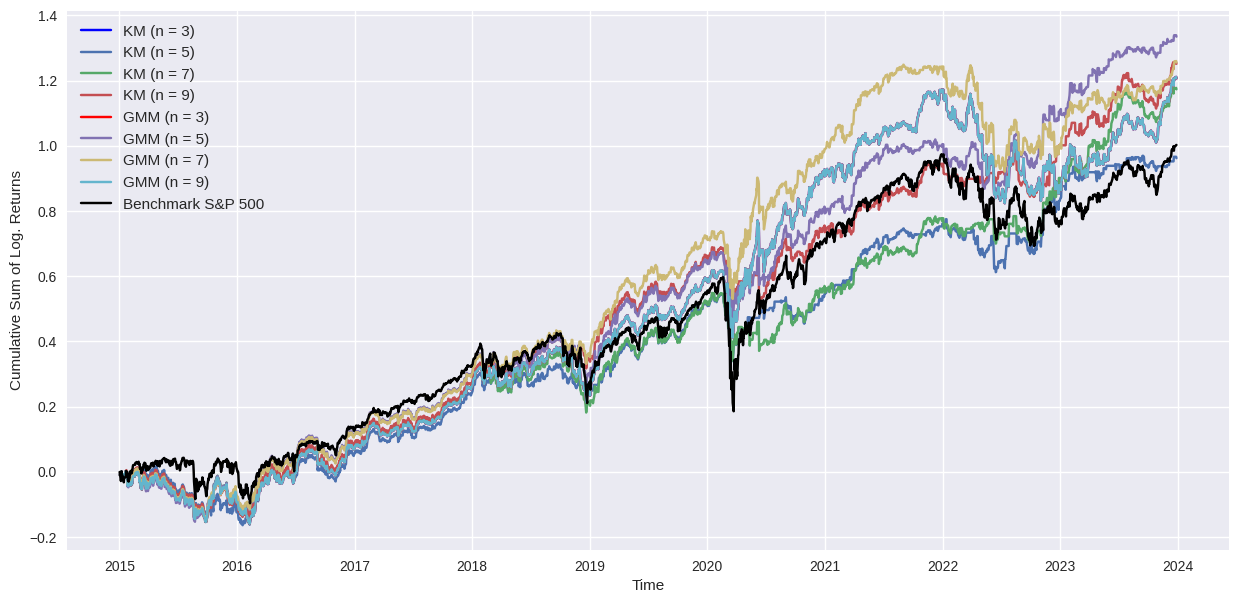

In [ ]:
plt.figure(figsize=(15, 7))

#plt.plot(plotDfTest['KM5']*2, label='KM (n = 3)T', color =  'blue', alpha = 1)

#plt.plot((plotDfTest['KM2']+plotDfTest['KM5']+plotDfTest['KM10']+plotDfTest['KM20'])/4, label='GMM (n = 3) AVG',color = 'red', alpha = 1)

#plt.plot((plotDfTest['KM2']+plotDfTest['KM5']+plotDfTest['KM10']+plotDfTest['KM20'])/2, label='GMM (n = 3) AVG',color = 'red', alpha = 1)


plt.plot(plotDfTest['KM2'], label='KM (n = 3)', color =  'blue', alpha = 1)
plt.plot(plotDfTest['KM5'], label='KM (n = 5)', alpha = 1)
plt.plot(plotDfTest['KM10'], label='KM (n = 7)', alpha = 1)
plt.plot(plotDfTest['KM20'], label='KM (n = 9)', alpha = 1)

plt.plot(plotDfTest['GM2'], label='GMM (n = 3)',color = 'red', alpha = 1)
plt.plot(plotDfTest['GM5'], label='GMM (n = 5)', alpha = 1)
plt.plot(plotDfTest['GM10'], label='GMM (n = 7)', alpha = 1)
plt.plot(plotDfTest['GM20'], label='GMM (n = 9)', alpha = 1)

plt.plot(plotDfTest['SPY'], label='Benchmark S&P 500', color = 'black', alpha = 0.99998)


plt.xlabel('Time', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)
#plt.title('Development of Equity Over Time')

#plt.grid(True)
plt.legend(fontsize=11)
plt.show()

Graph shows that most of the agents hav better performance on unseen data than S&P500.

In [ ]:
plotDfTestRet.to_csv('Test.csv', sep=',', encoding='utf-8', index=False, compression='gzip')

In [ ]:
Stats(plotDfTestRet)

<ipython-input-66-bf5549142154>:65: RuntimeWarning: invalid value encountered in scalar divide
  ir = ret.mean() / ret.std() * np.sqrt(len(plotDfTrainRet))


,TotRet,AvgRet,Std,MaxDrawdown,DownsideDev,SharpeRatioAnl,SharpeRatioTot,SortinoRatioAnl,SortinoRatioTot,InformationRatioTot,MW p-val
SPY,100.265,11.165,18.159,41.124,0.008,0.505,1.512,0.689,2.065,NaN,0.000
KM2,120.681,13.439,17.147,34.854,0.008,0.667,1.999,0.931,2.790,0.263,0.927
KM5,96.200,10.712,12.814,20.711,0.006,0.680,2.038,0.987,2.957,-0.059,0.133
KM10,117.331,13.066,14.043,20.776,0.006,0.788,2.361,1.122,3.364,0.239,0.458
KM20,125.156,13.937,13.511,20.776,0.006,0.884,2.648,1.250,3.746,0.353,0.529
GM2,120.681,13.439,17.147,34.854,0.008,0.667,1.999,0.931,2.790,0.263,0.927
GM5,133.484,14.864,14.368,20.776,0.006,0.895,2.683,1.278,3.830,0.460,0.537
GM10,125.571,13.983,15.946,32.795,0.007,0.751,2.252,1.066,3.196,0.337,0.598
GM20,120.681,13.439,17.147,34.854,0.008,0.667,1.999,0.931,2.790,0.263,0.927
KM5T,192.400,21.425,25.628,41.421,0.011,0.758,2.271,1.103,3.306,0.940,0.774


## 083 Deeper Look

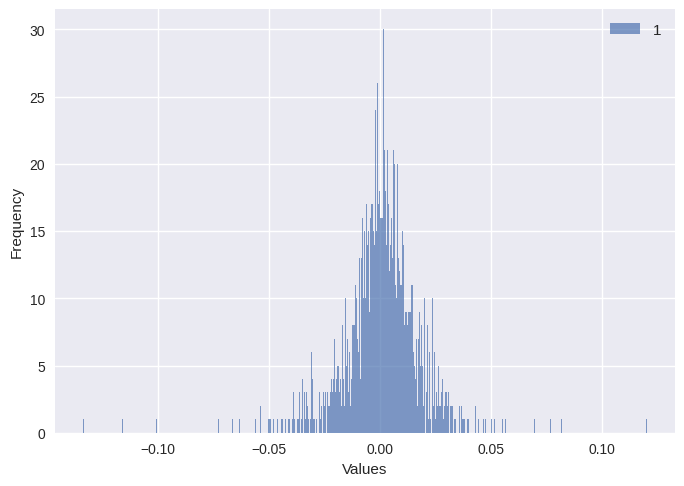

In [ ]:
plt.hist(plotDfTestRet['KM2AVG2'], bins=1110,label= '1', alpha=0.7)
#plt.hist(plotDfTestRet['SPY'], bins=111, label= '2',alpha=0.7)

plt.xlabel('Values', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

plt.legend(fontsize=11)
plt.show()

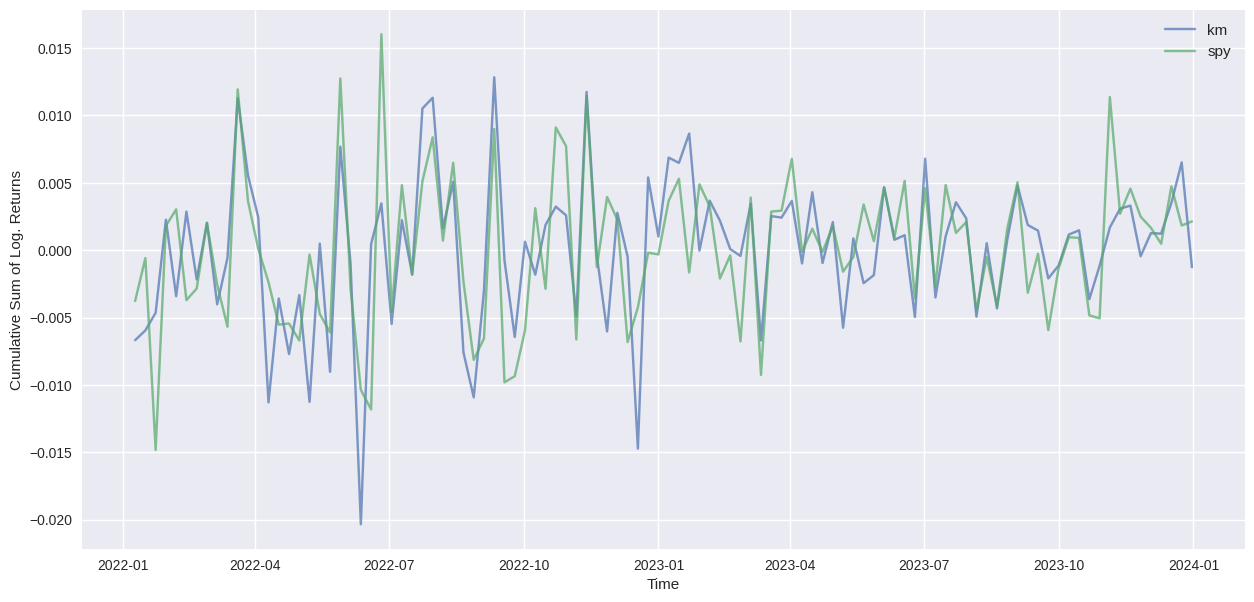

In [ ]:

plotDfGap = pd.DataFrame()
plotDfGap['gap'] = (plotDfTestRet['KM10'] - plotDfTestRet['SPY']).copy()
plotDfGap['km'] = (plotDfTestRet['GM10']).copy()
plotDfGap['spy'] = (plotDfTestRet['SPY']).copy()
plotDfGap = plotDfGap.loc['2022-01-01':'2024-12-31']

plt.figure(figsize=(15, 7))

plotDfGap = plotDfGap.resample('W').mean()

plt.plot(plotDfGap['km'],  label = 'km', alpha=0.7)
plt.plot(plotDfGap['spy'], label = 'spy', alpha=0.7)


plt.xlabel('Time', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)
#plt.title('Development of Equity Over Time')

#plt.grid(True)

plt.legend(fontsize=11)
plt.show()

### 084 Weight Allocation by Agents

In [ ]:
logEquityGM3, logPortfolioRetGM3, positionsListKM3 = RunSim2(trainClustersKM2, testClustersKM2, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityGM20, logPortfolioRetGM20, positionsListKM20 = RunSim2(trainClustersKM20, testClustersKM20, marketDfLogRetTest, actionsDf, switchDfTest)

logEquityKM5, logPortfolioRetGM5, positionsListKM5 = RunSim2(trainClustersKM5, testClustersKM5, marketDfLogRetTest, actionsDf, switchDfTest)
logEquityGM5, logPortfolioRetGM5, positionsListKM7 = RunSim2(trainClustersKM10, testClustersGM10, marketDfLogRetTest, actionsDf, switchDfTest)

<ipython-input-57-fc154dfae8e6>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if switchDfTrain["Switch"][current_state] == 0:  # If in low-volatility regime


In [ ]:
positionsListDfGM3 = pd.DataFrame(positionsListKM3)
positionsListDfGM3.index = marketDfLogRetTest.index[1:].copy()
positionsListDfGM3.columns = actionsDf.columns.copy()

positionsListDfGM20 = pd.DataFrame(positionsListKM20)
positionsListDfGM20.index = marketDfLogRetTest.index[1:].copy()
positionsListDfGM20.columns = actionsDf.columns.copy()

positionsListDfKM5 = pd.DataFrame(positionsListKM5)
positionsListDfKM5.index = marketDfLogRetTest.index[1:].copy()
positionsListDfKM5.columns = actionsDf.columns.copy()

positionsListDfKM7 = pd.DataFrame(positionsListKM7)
positionsListDfKM7.index = marketDfLogRetTest.index[1:].copy()
positionsListDfKM7.columns = actionsDf.columns.copy()

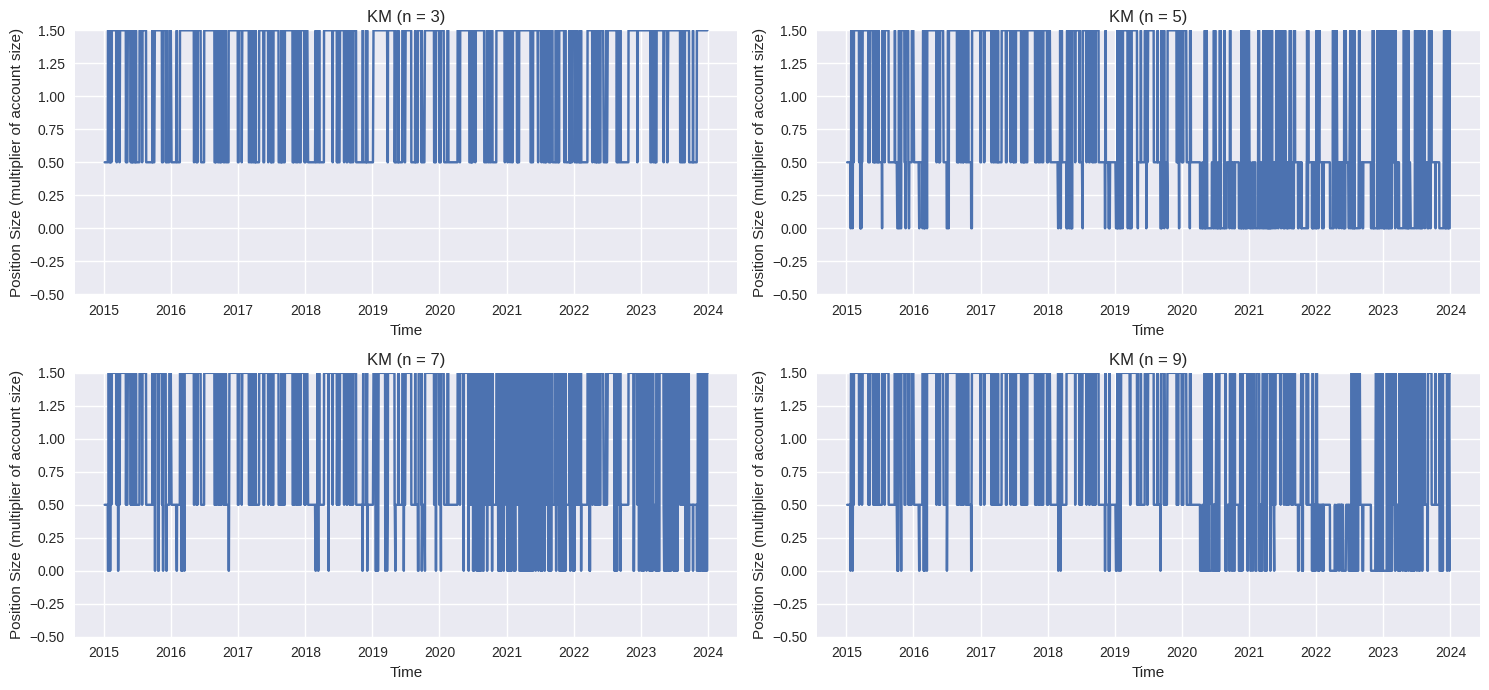

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))  # Creates a 2x2 grid of plots, each plot being square


# Plot for KM 3
axs[0, 0].plot(positionsListDfGM3['SPY'], label='KM (n = 3)', alpha=0.9985)
axs[0, 0].set_title('KM (n = 3)')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Position Size (multiplier of account size)')
axs[0, 0].set_ylim(-0.5, 1.5)
#axs[0, 0].legend()

# Plot for KM 5
axs[0, 1].plot(positionsListDfKM5['SPY'], label='KM (n = 5)', alpha=0.9985)
axs[0, 1].set_title('KM (n = 5)')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Position Size (multiplier of account size)')
axs[0, 1].set_ylim(-0.5, 1.5)

# Plot for KM 7
axs[1, 0].plot(positionsListDfKM7['SPY'], label='KM (n = 7)', alpha=0.99985)
axs[1, 0].set_title('KM (n = 7)')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Position Size (multiplier of account size)')
axs[1, 0].set_ylim(-0.5, 1.5)

# Plot for GMM 5
axs[1, 1].plot(positionsListDfGM20['SPY'], label='KM (n = 9)', alpha=0.9985)
axs[1, 1].set_title('KM (n = 9)')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Position Size (multiplier of account size)')
axs[1, 1].set_ylim(-0.5, 1.5)


plt.tight_layout()  # Adjusts plot parameters to give some padding and prevent overlap
plt.show()

Graphs show how agents change their position from leveraging to using only 50% of their buying power.

# 09 Final, Stacked Models


The code shows how different Q-learning agents, like K-means and Gaussian Mixture models, are combined to create a stronger strategy. By averaging the results from multiple models, this method uses the strengths of each agent to improve predictions and reduce the chance of overfitting. Stacking helps capture different patterns in the data, leading to more accurate and reliable forecasts. It also provides a safeguard against individual model biases and errors, making the overall strategy more robust and adaptable to changing market conditions.

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)
!ls "/content/drive/My Drive/Colab Notebooks/DIP RL"


Mounted at /content/drive
pokles.png	TestS1.csv  TestSA1.csv  train.png    TrainS3.csv   TrainSA3.csv
statistiky.png	TestS2.csv  TestSA2.csv  TrainS1.csv  TrainSA1.csv
test.png	TestS3.csv  TestSA3.csv  TrainS2.csv  TrainSA2.csv


In [ ]:
sim1Train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DIP RL/TrainSA1.csv',  encoding='utf-8', delimiter = ',')
sim1Test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DIP RL/TestSA1.csv', encoding='utf-8',delimiter = ',')
sim1Train = sim1Train.set_index(sim1Train.Date)
sim1Test = sim1Test.set_index(sim1Test.Date)

sim2Train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DIP RL/TrainSA2.csv', encoding='utf-8',delimiter = ',')
sim2Test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DIP RL/TestSA2.csv', encoding='utf-8',delimiter = ',')
sim2Train = sim2Train.set_index(sim2Train.Date)
sim2Test = sim2Test.set_index(sim2Test.Date)

sim3Train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DIP RL/TrainSA3.csv', encoding='utf-8',delimiter = ',')
sim3Test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DIP RL/TestSA3.csv', encoding='utf-8',delimiter = ',')
sim3Train = sim3Train.set_index(sim3Train.Date)
sim3Test = sim3Test.set_index(sim3Test.Date)

In [ ]:
sim1Train['AVG'] = (sim1Train['KM2']+sim1Train['KM5']+sim1Train['KM10']+sim1Train['KM20'] + sim1Train['GM20']+sim1Train['GM5']+sim1Train['GM10']+sim1Train['GM20'])/8
sim1Test['AVG'] = (sim1Test['KM2']+sim1Test['KM5']+sim1Test['KM10']+sim1Test['KM20'] + sim1Test['GM20']+sim1Test['GM5']+sim1Test['GM10']+sim1Test['GM20'])/8

sim2Train['AVG'] = (sim2Train['KM2']+sim2Train['KM5']+sim2Train['KM10']+sim2Train['KM20'] + sim2Train['GM20']+sim2Train['GM5']+sim2Train['GM10']+sim2Train['GM20'])/8
sim2Test['AVG'] = (sim2Test['KM2']+sim2Test['KM5']+sim2Test['KM10']+sim2Test['KM20'] + sim2Test['GM20']+sim2Test['GM5']+sim2Test['GM10']+sim2Test['GM20'])/8

sim3Train['AVG'] = (sim3Train['KM2']+sim3Train['KM5']+sim3Train['KM10']+sim3Train['KM20'])/4
sim3Test['AVG'] = (sim3Test['KM2']+sim3Test['KM5']+sim3Test['KM10']+sim3Test['KM20'])/4

sim4Train = pd.DataFrame()
sim4Test = pd.DataFrame()

sim4Train['AVG'] = (plotDfTrainRet['KM2']+plotDfTrainRet['KM5']+plotDfTrainRet['KM10']+plotDfTrainRet['KM20'])/4
sim4Test['AVG'] = (plotDfTestRet['KM2']+plotDfTestRet['KM5']+plotDfTestRet['KM10']+plotDfTestRet['KM20'])/4

In [ ]:
sim1Train

,Date,SPY,KM2,KM5,KM10,KM20,GM2,GM5,GM10,GM20,AVG
Date,,,,,,,,,,,
1995-10-16,1995-10-16,-0.004809,0.006673,0.006673,0.006673,0.006673,0.006673,0.006673,0.006673,0.006673,0.006673
1995-10-17,1995-10-17,0.006673,0.002921,0.002921,0.002921,0.000000,0.002921,0.002921,0.002921,0.002921,0.002556
1995-10-18,1995-10-18,0.002921,0.004764,0.004764,0.004764,0.000000,0.004764,0.004764,0.004764,0.004764,0.004168
1995-10-19,1995-10-19,0.004764,-0.006090,-0.006090,-0.006090,-0.006090,-0.006090,-0.006090,-0.006090,-0.006090,-0.006090
1995-10-20,1995-10-20,-0.006090,-0.002127,-0.002127,-0.002127,-0.002127,-0.002127,-0.002127,-0.002127,-0.002127,-0.002127
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-23,2014-12-23,0.001348,0.000096,0.000096,0.000096,0.000000,0.000096,0.000096,0.000096,0.000096,0.000084
2014-12-24,2014-12-24,0.000096,0.003219,0.003219,0.003219,0.000000,0.003219,0.003219,0.003219,0.003219,0.002817
2014-12-26,2014-12-26,0.003219,0.001343,0.001343,0.001343,0.000000,0.001343,0.001343,0.001343,0.001343,0.001175


In [ ]:
stackedTrainDf = pd.DataFrame()
stackedTestDf = pd.DataFrame()

stackedTrainDf['S1'] = sim1Train['AVG'].copy()
stackedTrainDf['S2'] = sim2Train['AVG'].copy()
stackedTrainDf['S3'] = sim3Train['AVG'].copy()
stackedTrainDf['S4'] = sim4Train['AVG'].copy()
stackedTrainDf['S42'] = stackedTrainDf['S4'] * 2
stackedTrainDf['S5'] = (stackedTrainDf.S1 + stackedTrainDf.S2+stackedTrainDf.S3+stackedTrainDf.S4+stackedTrainDf.S42)/5


stackedTestDf['S1'] = sim1Test['AVG'].copy()
stackedTestDf['S2'] = sim2Test['AVG'].copy()
stackedTestDf['S3'] = sim3Test['AVG'].copy()
stackedTestDf['S4'] = sim4Test['AVG'].copy()
stackedTestDf['S42'] = stackedTestDf['S4'] * 2
stackedTestDf['S5'] = (stackedTestDf.S1 + stackedTestDf.S2+stackedTestDf.S3+stackedTestDf.S4+stackedTestDf.S42)/5

stackedTrainDf['SPY'] = marketDfLogRetTrain['SPY'].shift(-1)
stackedTestDf['SPY'] = marketDfLogRetTest['SPY'].shift(-1)

In [ ]:
stackedTrainDf

,S1,S2,S3,S4,S42,S5,SPY
Date,,,,,,,
1995-10-16,0.006673,0.010010,0.010009,0.003337,0.006673,0.007341,0.006673
1995-10-17,0.002556,0.004383,0.004383,0.001461,0.002922,0.003141,0.002922
1995-10-18,0.004168,0.007144,0.007144,0.002382,0.004763,0.005120,0.004763
1995-10-19,-0.006090,-0.009135,-0.009134,-0.003045,-0.006090,-0.006699,-0.006090
1995-10-20,-0.002127,-0.003191,-0.003191,-0.001063,-0.002127,-0.002340,-0.002127
...,...,...,...,...,...,...,...
2014-12-23,0.000084,0.000144,0.000096,0.000144,0.000288,0.000151,0.000096
2014-12-24,0.002817,0.004829,0.004829,0.004830,0.009660,0.005393,0.003220
2014-12-26,0.001175,0.002013,0.002014,0.002013,0.004027,0.002248,0.001342


In [ ]:
stackedTrainDfCum = stackedTrainDf.cumsum()

stackedTestDfCum = stackedTestDf.cumsum()

stackedTrainDfCum.index = pd.to_datetime(stackedTrainDfCum.index)
stackedTestDfCum.index = pd.to_datetime(stackedTestDfCum.index)

##091 Train Performance

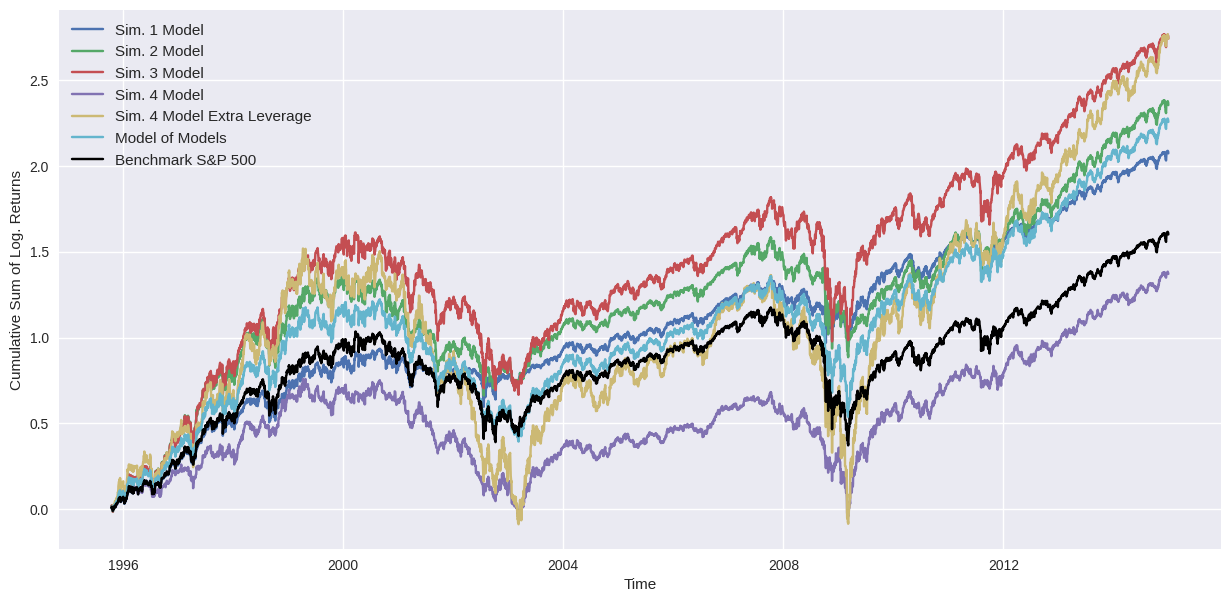

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(stackedTrainDfCum['S1'],label='Sim. 1 Model', alpha = 1)
plt.plot(stackedTrainDfCum['S2'],label='Sim. 2 Model', alpha = 1)

plt.plot(stackedTrainDfCum['S3'],label='Sim. 3 Model', alpha = 1)
plt.plot(stackedTrainDfCum['S4'],label='Sim. 4 Model', alpha = 1)

plt.plot(stackedTrainDfCum['S42'],label='Sim. 4 Model Extra Leverage', alpha = 1)

plt.plot(stackedTrainDfCum['S5'],label='Model of Models', alpha = 1)

plt.plot(stackedTrainDfCum['SPY'], label='Benchmark S&P 500', color = 'black', alpha = 0.99998)


plt.xlabel('Time', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)
#plt.title('Development of Equity Over Time')

#plt.grid(True)
plt.legend(fontsize=11)
plt.show()

In [ ]:
Stats(stackedTrainDf)

<ipython-input-66-bf5549142154>:65: RuntimeWarning: invalid value encountered in scalar divide
  ir = ret.mean() / ret.std() * np.sqrt(len(plotDfTrainRet))


,TotRet,AvgRet,Std,MaxDrawdown,DownsideDev,SharpeRatioAnl,SharpeRatioTot,SortinoRatioAnl,SortinoRatioTot,InformationRatioTot,MW p-val
S1,207.306,10.803,16.630,39.338,0.007,0.529,2.319,0.762,3.337,1.906,0.000
S2,235.398,12.266,23.557,71.133,0.011,0.436,1.909,0.615,2.693,2.264,0.625
S3,274.158,14.286,27.324,94.542,0.012,0.450,1.970,0.630,2.759,2.536,0.349
S4,137.044,7.141,18.130,80.312,0.008,0.284,1.242,0.394,1.727,-0.537,0.078
S42,274.089,14.283,36.260,160.624,0.016,0.339,1.484,0.472,2.068,1.231,0.635
S5,225.599,11.756,23.378,82.936,0.010,0.417,1.828,0.586,2.567,2.121,0.006
SPY,160.042,8.340,20.029,80.273,0.009,0.317,1.387,0.442,1.938,NaN,0.179


##092 Test Performance

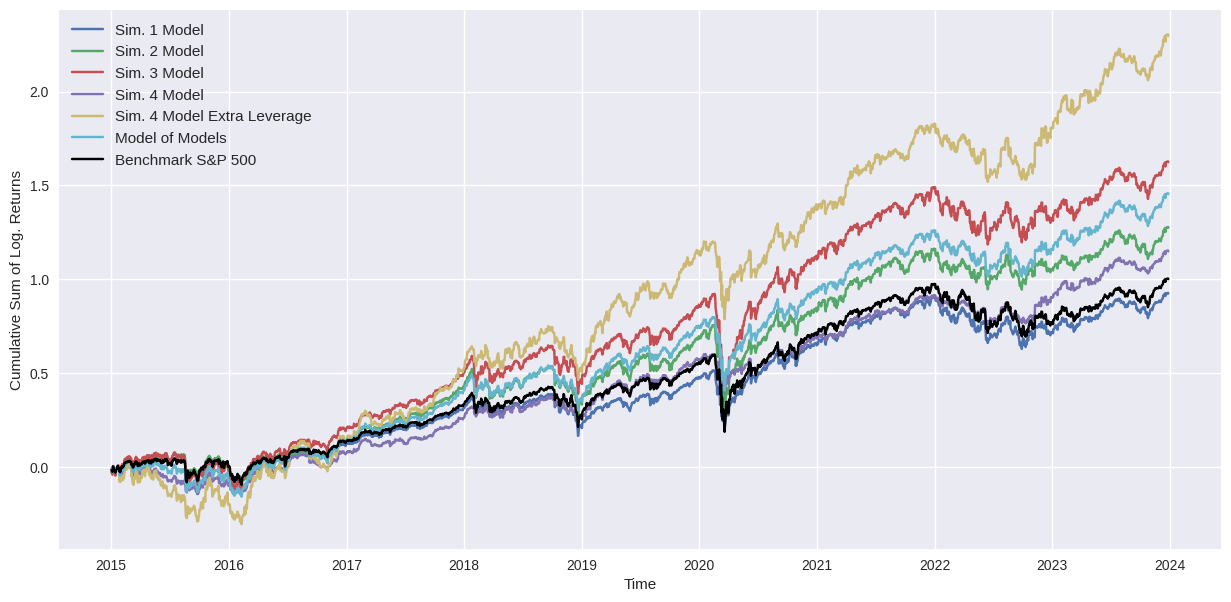

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(stackedTestDfCum['S1'],label='Sim. 1 Model', alpha = 1)
plt.plot(stackedTestDfCum['S2'],label='Sim. 2 Model', alpha = 1)

plt.plot(stackedTestDfCum['S3'],label='Sim. 3 Model', alpha = 1)
plt.plot(stackedTestDfCum['S4'],label='Sim. 4 Model', alpha = 1)

plt.plot(stackedTestDfCum['S42'],label='Sim. 4 Model Extra Leverage', alpha = 1)
plt.plot(stackedTestDfCum['S5'],label='Model of Models', alpha = 1)

plt.plot(stackedTestDfCum['SPY'], label='Benchmark S&P 500', color = 'black', alpha = 0.99998)


plt.xlabel('Time', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)
#plt.title('Development of Equity Over Time')

#plt.grid(True)
plt.legend(fontsize=11)
plt.show()

In [ ]:
Stats(stackedTestDf)

<ipython-input-66-bf5549142154>:65: RuntimeWarning: invalid value encountered in scalar divide
  ir = ret.mean() / ret.std() * np.sqrt(len(plotDfTrainRet))


,TotRet,AvgRet,Std,MaxDrawdown,DownsideDev,SharpeRatioAnl,SharpeRatioTot,SortinoRatioAnl,SortinoRatioTot,InformationRatioTot,MW p-val
S1,92.343,10.283,15.455,31.014,0.007,0.536,1.606,0.733,2.196,-0.563,0.000
S2,127.401,14.187,21.341,50.996,0.010,0.571,1.711,0.776,2.325,1.431,0.771
S3,162.338,18.077,23.292,52.347,0.011,0.690,2.068,0.949,2.845,2.291,0.429
S4,114.842,12.788,13.314,20.736,0.006,0.810,2.428,1.156,3.464,0.558,0.200
S42,229.684,25.577,26.628,41.472,0.012,0.885,2.653,1.267,3.797,3.209,0.539
S5,145.322,16.183,19.323,39.208,0.009,0.734,2.199,1.019,3.055,2.779,0.085
SPY,100.029,11.139,18.159,41.124,0.008,0.503,1.508,0.687,2.059,NaN,0.401


Results show

# 10 MC Sim


Monte Carlo simulation is a technique used to estimate future returns by running a large number of simulations based on historical data and assumed probability distributions. The method involves generating a range of possible outcomes for future returns by randomly sampling from the data’s statistical properties, such as mean and volatility, and applying them to model the future. By simulating thousands of possible scenarios, it provides a comprehensive view of the potential outcomes, including the likelihood of various return levels. This approach helps assess risk and uncertainty, providing valuable insights for making more informed investment decisions.

In [ ]:
data = stackedTestDf['S1']

# Perform kernel density estimation (KDE) to estimate the PDF of your data
kde = gaussian_kde(data, bw_method=0.09)

# Define your custom distribution class based on the estimated KDE
class CustomDistribution:
    def __init__(self, kde):
        self.kde = kde

    def pdf(self, x):
        return self.kde.evaluate(x)

    def rvs(self, size):
        # Generate random samples from the custom distribution
        return np.random.choice(data, size=size)  # Sample from your actual data


custom_dist = CustomDistribution(kde)

In [ ]:
data = stackedTestDf['S1']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim1 = CustomDistribution(kde)

data = stackedTestDf['S2']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim2 = CustomDistribution(kde)

data = stackedTestDf['S3']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim3 = CustomDistribution(kde)

data = stackedTestDf['S4']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim4 = CustomDistribution(kde)

data = stackedTestDf['S42']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim42 = CustomDistribution(kde)

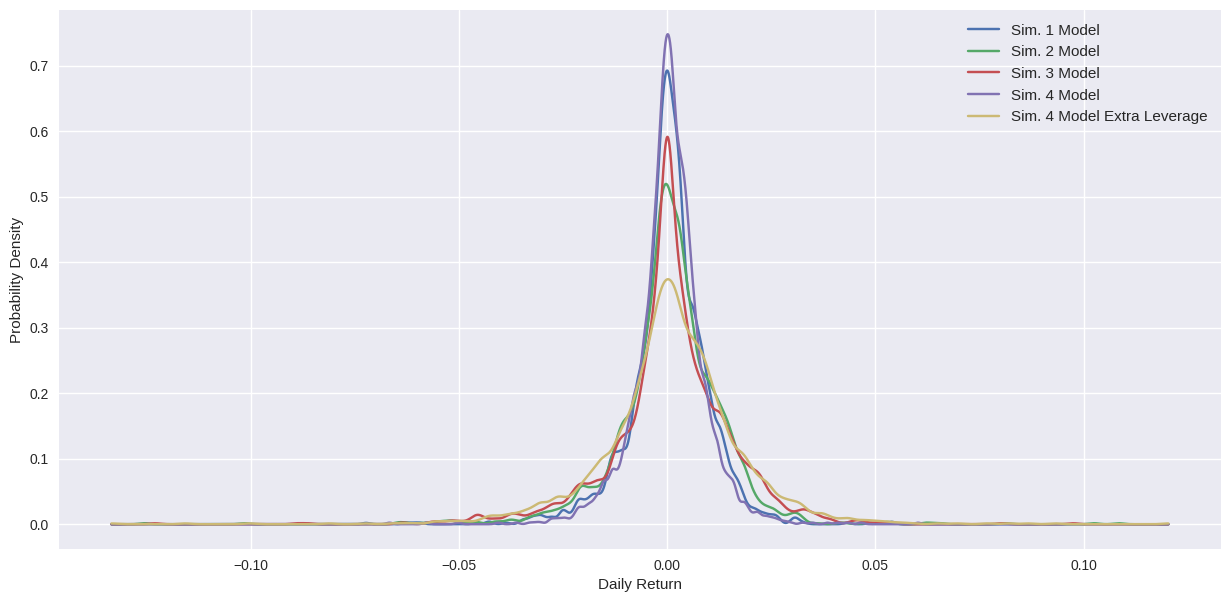

In [ ]:
x_values = np.linspace(data.min(), data.max(), 10000)

# Evaluate the PDF at the specified x values
pdf_valuesSim1 = custom_distSim1.pdf(x_values)
pdf_valuesSim2 = custom_distSim2.pdf(x_values)
pdf_valuesSim3 = custom_distSim3.pdf(x_values)
pdf_valuesSim4 = custom_distSim4.pdf(x_values)
pdf_valuesSim42 = custom_distSim42.pdf(x_values)

# Plot the estimated PDF
plt.figure(figsize=(15, 7))
plt.plot(x_values, pdf_valuesSim1/100, label='Sim. 1 Model')
plt.plot(x_values, pdf_valuesSim2/100, label='Sim. 2 Model')
plt.plot(x_values, pdf_valuesSim3/100, label='Sim. 3 Model')
plt.plot(x_values, pdf_valuesSim4/100, label='Sim. 4 Model')
plt.plot(x_values, pdf_valuesSim42/100, label='Sim. 4 Model Extra Leverage')

plt.xlabel('Daily Return', fontsize=11)
plt.ylabel('Probability Density', fontsize=11)

plt.legend(fontsize=11)
plt.grid(True)
plt.show()

## 101 Run MC Sim

In [ ]:
num_simulations = 10000
num_samples_per_simulation = 252  # 252 Days -> 1 year

# Generate random samples for each simulation
simulation_results = []
for _ in range(num_simulations):
    samples = custom_distSim42.rvs(size=num_samples_per_simulation)

    simulation_results.append(samples)

In [ ]:
simResDf = pd.DataFrame(simulation_results).T

simResDfCumSum = simResDf.cumsum(axis=0)

In [ ]:
simResDfCumSum

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.003984,0.002807,0.008639,-0.012283,0.029689,0.006665,0.002857,0.000311,0.002266,0.082028,...,0.010382,-0.007151,-0.001571,0.007566,0.001682,0.011088,0.014591,0.003808,0.031299,-0.009534
1,-0.016153,0.007161,0.008380,-0.002860,0.020992,-0.004879,-0.009940,-0.000405,-0.001540,0.083813,...,0.022172,-0.023635,0.030388,0.032183,0.010372,0.007739,0.009487,0.021589,0.034951,-0.012748
2,-0.021102,0.003470,0.005076,-0.000434,0.021135,0.002177,0.016518,-0.007740,-0.003180,0.098033,...,0.014882,-0.017451,0.043022,0.054135,0.016854,0.009188,-0.002682,0.021279,0.028965,-0.032915
3,-0.013561,0.046596,-0.048635,0.005708,-0.005872,-0.018926,0.013962,-0.020473,-0.001855,0.091169,...,0.013056,0.010172,0.024343,0.055859,0.013392,0.002489,-0.000559,0.031323,0.016717,-0.034799
4,0.001880,0.080606,-0.050369,0.016890,0.001183,-0.029963,0.007228,-0.022208,0.003408,0.083834,...,-0.000540,0.029130,0.023967,0.069131,0.022767,-0.008688,0.002442,0.025710,0.023967,-0.031444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.283119,0.119290,-0.035765,0.336226,0.511791,0.505473,0.109497,0.155016,0.601868,0.137915,...,-0.377251,-0.382132,0.356323,0.564940,0.256461,-0.028604,0.270407,0.345829,0.036670,-0.071763
248,0.305932,0.120228,-0.003611,0.341798,0.541242,0.505055,0.110092,0.165537,0.610027,0.147240,...,-0.375552,-0.390210,0.360442,0.565869,0.259102,-0.019593,0.244043,0.345708,0.041710,-0.127630
249,0.306517,0.152532,-0.004339,0.321313,0.546155,0.500959,0.103363,0.208480,0.602977,0.164125,...,-0.367968,-0.406369,0.378031,0.568475,0.271566,-0.007332,0.243542,0.350947,0.040981,-0.131348
250,0.294551,0.130909,0.026477,0.340194,0.534359,0.499858,0.129412,0.205131,0.572815,0.168752,...,-0.336121,-0.419984,0.364683,0.576134,0.262635,-0.015347,0.286734,0.353069,0.028500,-0.138077


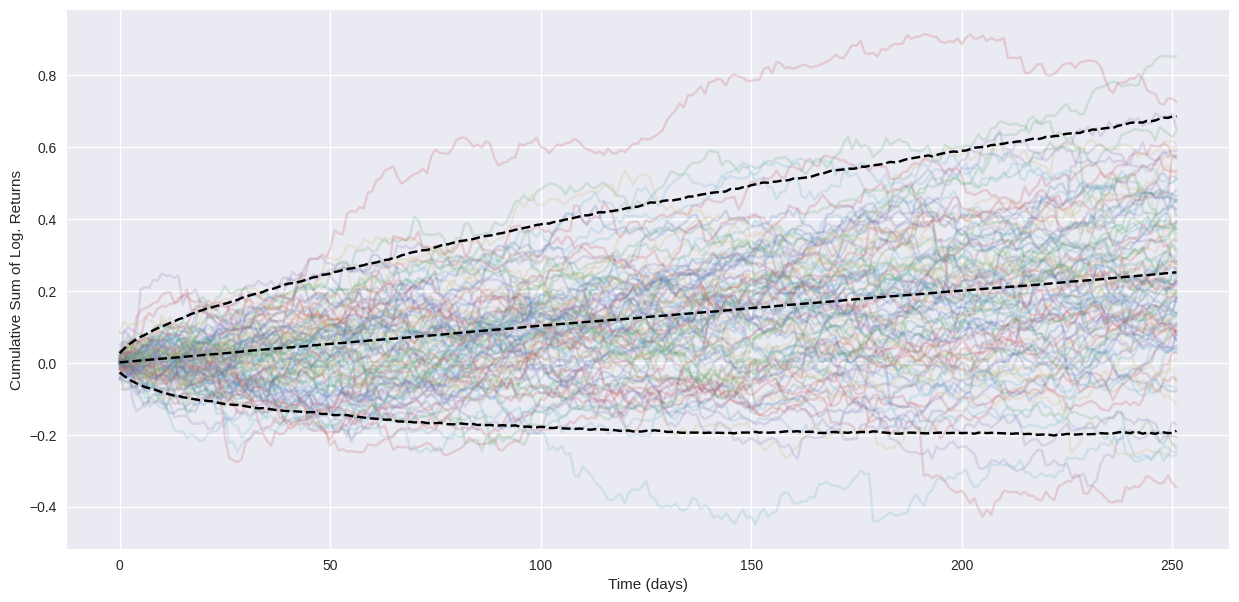

In [ ]:
plt.figure(figsize=(15, 7))

cumulative_sum_df = simResDfCumSum.copy()
# Plot individual trajectories with shadows
for col in cumulative_sum_df.columns:
    #plt.fill_between(cumulative_sum_df.index, cumulative_sum_df[col], alpha=0.1)
    plt.plot(cumulative_sum_df.index, cumulative_sum_df[col], label=col, alpha=0.2)

    if col == 100:
      break

# Calculate mean trajectory
mean_trajectory = cumulative_sum_df.mean(axis=1)

# Calculate 5% and 95% bands
band_5 = cumulative_sum_df.quantile(0.05, axis=1)
band_95 = cumulative_sum_df.quantile(0.95, axis=1)

# Plot mean trajectory
plt.plot(cumulative_sum_df.index, mean_trajectory, color='black', linestyle='--', label='band_95')


plt.plot(cumulative_sum_df.index, band_5, color='black', linestyle='--', label='band_05')
plt.plot(cumulative_sum_df.index, band_95, color='black', linestyle='--', label='band_95')


# Plot 5% and 95% bands
#plt.fill_between(cumulative_sum_df.index, band_5, band_95, color='gray', alpha=0.3, label='5%-95% Band')

# Add labels and legend
plt.xlabel('Time (days)', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)

plt.grid(True)
plt.show()

This graph visualizes the trajectories of multiple simulated outcomes over time, represented by the cumulative sum of log returns. Each individual trajectory is plotted with low opacity, giving a shadow-like effect, while the mean trajectory is shown as a black dashed line. The 5% and 95% quantiles are also plotted to show the uncertainty range around the mean. These quantiles represent the lower and upper bounds of the simulated returns, providing insight into the potential variability of the investment's performance. The plot effectively combines individual simulations with a summary of the central tendency and variability, helping to understand the range of possible outcomes over time.

## 102 Rest Sim

In [ ]:
# Perform Monte Carlo simulation
num_simulations = 10000  # Number of simulations
num_samples_per_simulation = 252  # Number of samples per simulation


In [ ]:
def McSim(num_simulations, num_samples_per_simulation,custom_distSim):
  simulation_results = []
  for _ in range(num_simulations):
      samples = custom_distSim.rvs(size=num_samples_per_simulation)

      simulation_results.append(samples)
      del samples

  simResDf = pd.DataFrame(simulation_results).T
  simResDfCumSum = simResDf.cumsum(axis=0)

  del simResDf

  return simResDfCumSum

In [ ]:
data = stackedTestDf['S1']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim1 = CustomDistribution(kde)

simResDfCumSum1 = pd.DataFrame(McSim(num_simulations, num_samples_per_simulation, custom_distSim1))

#----------------
data = stackedTestDf['S2']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim2 = CustomDistribution(kde)
simResDfCumSum2 = McSim(num_simulations, num_samples_per_simulation, custom_distSim2).copy()

#---------------------
data = stackedTestDf['S3']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim3 = CustomDistribution(kde)
simResDfCumSum3 = McSim(num_simulations, num_samples_per_simulation, custom_distSim3).copy()

#---------------------
data = stackedTestDf['S4']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim4 = CustomDistribution(kde)
simResDfCumSum4 = McSim(num_simulations, num_samples_per_simulation, custom_distSim4).copy()

#---------------------
data = stackedTestDf['S42']
kde = gaussian_kde(data, bw_method=0.09)
custom_distSim42 = CustomDistribution(kde)
simResDfCumSum42 = McSim(num_simulations, num_samples_per_simulation, custom_distSim42).copy()

In [ ]:
import seaborn as sns

In [ ]:
sns.color_palette()[1]

(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

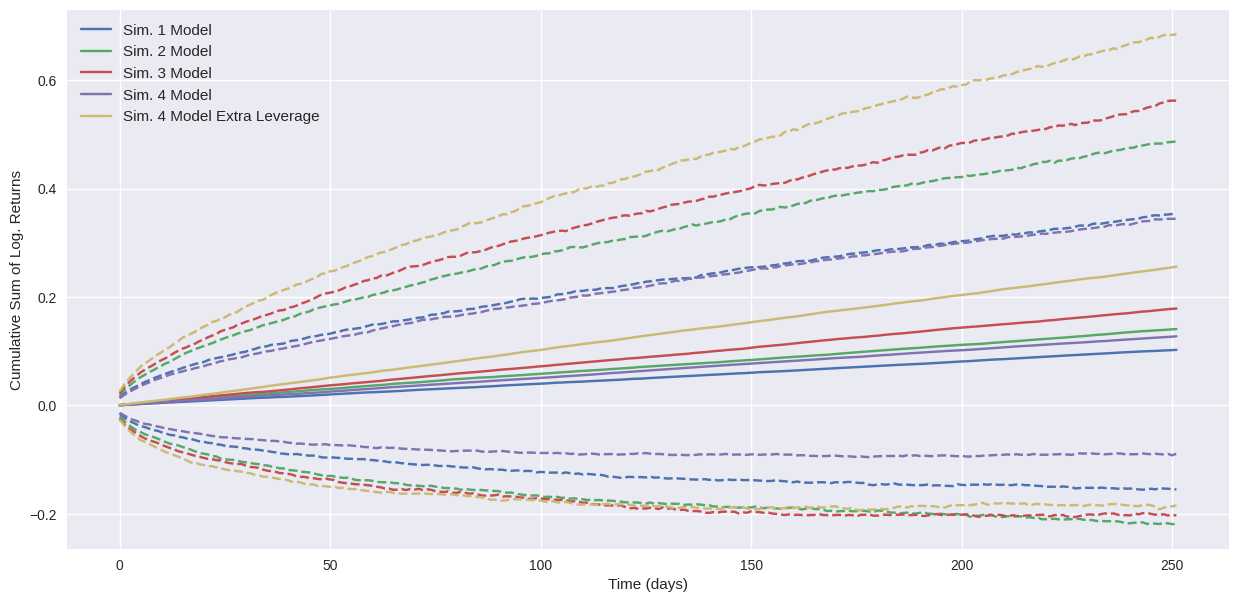

In [ ]:
# Plot trajectories with shadows
plt.figure(figsize=(15, 7))

# Calculate mean trajectory
mean_trajectory1 = simResDfCumSum1.mean(axis=1)
band_5_1 = simResDfCumSum1.quantile(0.05, axis=1)
band_95_1 = simResDfCumSum1.quantile(0.95, axis=1)

mean_trajectory2 = simResDfCumSum2.mean(axis=1)
band_5_2 = simResDfCumSum2.quantile(0.05, axis=1)
band_95_2 = simResDfCumSum2.quantile(0.95, axis=1)

mean_trajectory3 = simResDfCumSum3.mean(axis=1)
band_5_3 = simResDfCumSum3.quantile(0.05, axis=1)
band_95_3 = simResDfCumSum3.quantile(0.95, axis=1)

mean_trajectory4 = simResDfCumSum4.mean(axis=1)
band_5_4 = simResDfCumSum4.quantile(0.05, axis=1)
band_95_4 = simResDfCumSum4.quantile(0.95, axis=1)

mean_trajectory42 = simResDfCumSum42.mean(axis=1)
band_5_42 = simResDfCumSum42.quantile(0.05, axis=1)
band_95_42 = simResDfCumSum42.quantile(0.95, axis=1)


# Plot mean trajectory
plt.plot(cumulative_sum_df.index, mean_trajectory1, color = sns.color_palette()[0],  linestyle='-', label='Sim. 1 Model')
plt.plot(cumulative_sum_df.index, band_5_1,  color = sns.color_palette()[0], linestyle='--')
plt.plot(cumulative_sum_df.index, band_95_1,  color = sns.color_palette()[0], linestyle='--')

plt.plot(cumulative_sum_df.index, mean_trajectory2, color = sns.color_palette()[1],  linestyle='-', label='Sim. 2 Model')
plt.plot(cumulative_sum_df.index, band_5_2,  color = sns.color_palette()[1], linestyle='--')
plt.plot(cumulative_sum_df.index, band_95_2,  color = sns.color_palette()[1], linestyle='--')

plt.plot(cumulative_sum_df.index, mean_trajectory3, color = sns.color_palette()[2],  linestyle='-', label='Sim. 3 Model')
plt.plot(cumulative_sum_df.index, band_5_3,  color = sns.color_palette()[2], linestyle='--')
plt.plot(cumulative_sum_df.index, band_95_3,  color = sns.color_palette()[2], linestyle='--')

plt.plot(cumulative_sum_df.index, mean_trajectory4, color = sns.color_palette()[3],  linestyle='-', label='Sim. 4 Model')
plt.plot(cumulative_sum_df.index, band_5_4,  color = sns.color_palette()[3], linestyle='--')
plt.plot(cumulative_sum_df.index, band_95_4,  color = sns.color_palette()[3], linestyle='--')

plt.plot(cumulative_sum_df.index, mean_trajectory42, color = sns.color_palette()[4],  linestyle='-', label='Sim. 4 Model Extra Leverage')
plt.plot(cumulative_sum_df.index, band_5_42,  color = sns.color_palette()[4], linestyle='--')
plt.plot(cumulative_sum_df.index, band_95_42,  color = sns.color_palette()[4], linestyle='--')


# Plot 5% and 95% bands
#plt.fill_between(cumulative_sum_df.index, band_5, band_95, color='gray', alpha=0.3, label='5%-95% Band')

# Add labels and legend
plt.xlabel('Time (days)', fontsize=11)
plt.ylabel('Cumulative Sum of Log. Returns', fontsize=11)
plt.legend(fontsize=11)

plt.grid(True)
plt.show()

------------

**A deeper explanation of everything observed in this code is discussed in the written part of the diploma thesis.**